In [2]:
#import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
train_dir = '/content/drive/MyDrive/feature_train_test_data/reduced_train_100'
test_dir = '/content/drive/MyDrive/feature_train_test_data/5_class_reduced_test_50'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data augmentation for image sequences
def augment_sequence(sequence, img_size=(112, 112)):
    augmented_seq = []
    for img in sequence:
        # applied random transformations
        if np.random.random() > 0.5:

            img = cv2.flip(img, 1)

        # random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-15, 15)
            height, width = img.shape[:2]
            matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
            img = cv2.warpAffine(img, matrix, (width, height))

        # random brightness variation
        if np.random.random() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            img = np.clip(img * brightness, 0, 1)

        augmented_seq.append(img)

    return np.array(augmented_seq)

In [6]:
# defined the enhanced data generator with augmentation
class SignLanguageSequence(Sequence):
    def __init__(self, root_dir, classes, sequence_length=16, batch_size=8, img_size=(112,112), augment=False, **kwargs):
        super().__init__(**kwargs)
        self.root_dir = root_dir
        self.classes = classes
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.samples = []
        self.labels = []
        self.label_encoder = LabelEncoder().fit(classes)
        self._prepare_samples()

        self._print_class_distribution()

    def _prepare_samples(self):
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, cls)
            frames = sorted([
                os.path.join(class_dir, f)
                for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            for i in range(0, len(frames), self.sequence_length):
                chunk = frames[i:i+self.sequence_length]
                if len(chunk) == self.sequence_length:
                    self.samples.append(chunk)
                    self.labels.append(cls)

                elif len(chunk) >= self.sequence_length // 2:
                    # pad with duplicates of the last frame
                    padding = [chunk[-1]] * (self.sequence_length - len(chunk))
                    self.samples.append(chunk + padding)
                    self.labels.append(cls)

        if len(self.samples) == 0:
            raise ValueError("No valid sequences found.")

    def _print_class_distribution(self):
        class_counts = {}
        for label in self.labels:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1

        print("Class distribution:")
        for cls, count in class_counts.items():
            print(f"{cls}: {count} sequences")

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        X = []
        for chunk in batch_samples:
            imgs = []
            for f in chunk:
                img = cv2.imread(f)
                if img is None:
                    raise ValueError(f"Could not read image: {f}")
                img = cv2.resize(img, self.img_size)
                img = img.astype(np.float32) / 255.0

                # apply augmentation if enabled
                if self.augment:

                    if np.random.random() > 0.5:
                        img = cv2.flip(img, 1)


                    if np.random.random() > 0.5:
                        angle = np.random.uniform(-15, 15)
                        height, width = img.shape[:2]
                        matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
                        img = cv2.warpAffine(img, matrix, (width, height))

                    if np.random.random() > 0.5:
                        brightness = np.random.uniform(0.8, 1.2)
                        img = np.clip(img * brightness, 0, 1)

                imgs.append(img)

            sequence = np.array(imgs)
            X.append(sequence)

        X = np.array(X)
        y = tf.keras.utils.to_categorical(
            self.label_encoder.transform(batch_labels),
            num_classes=len(self.classes)
        )
        return X, y

In [7]:
# defined the improved model architecture
def build_cnn_lstm(img_size, num_classes, dropout_rate=0.3, base_model='vgg16'):
    if base_model == 'vgg16':
        base = VGG16(include_top=False, weights='imagenet', input_shape=img_size + (3,))
    elif base_model == 'mobilenet':
        base = MobileNetV2(include_top=False, weights='imagenet', input_shape=img_size + (3,), alpha=0.75)
    else:
        raise ValueError("Unsupported base model")

    # froze some layers, but not all
    for layer in base.layers[:-4]:  # freze all except the last 4 layers
        layer.trainable = False


    feature_extractor = models.Sequential([
        base,
        layers.GlobalAveragePooling2D()
    ])

    # main model
    model = models.Sequential([
        layers.TimeDistributed(
            feature_extractor,
            input_shape=(16,) + img_size + (3,)
        ),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Dropout(dropout_rate),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate/2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [8]:
# set up and train the model
# Get classes
all_classes = sorted(os.listdir(train_dir))
selected_classes = all_classes[-5:]  # use the last 5 classes as in your code
print(f"Training on classes: {selected_classes}")

# created data generators with augmentation for training
train_gen = SignLanguageSequence(
    train_dir,
    selected_classes,
    sequence_length=16,
    batch_size=8,
    img_size=(112, 112),
    augment=True  # enabled augmentation for training
)

test_gen = SignLanguageSequence(
    test_dir,
    selected_classes,
    sequence_length=16,
    batch_size=8,
    img_size=(112, 112),
    augment=False  # no augmentation for testing
)

# check if GPU is available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# build model - MobileNetV2 for better speed and comparable accuracy
model = build_cnn_lstm(
    img_size=(112, 112),
    num_classes=len(selected_classes),
    dropout_rate=0.3,
    base_model='mobilenet'  # can change to 'vgg16'
)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_sign_language_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    callbacks=callbacks
)

Training on classes: ['I', 'beautiful', 'quiet', 'tall', 'you']
Class distribution:
I: 6 sequences
beautiful: 6 sequences
quiet: 6 sequences
tall: 6 sequences
you: 6 sequences
Class distribution:
I: 3 sequences
beautiful: 3 sequences
quiet: 3 sequences
tall: 3 sequences
you: 3 sequences
Num GPUs Available: 1


<ipython-input-7-b80d23f6efc8>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet', input_shape=img_size + (3,), alpha=0.75)


5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 1280)       │     1,382,064 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 256)        │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,015,093 (11.50 MB)

 Trainable params: 1,942,885 (7.41 MB)

 Non-trainable params: 1,072,208 (4.09 MB)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65s/step - accuracy: 0.2031 - loss: 2.3387 
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_sign_language_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 510s 143s/step - accuracy: 0.1958 - loss: 2.3319 - val_accuracy: 0.2000 - val_loss: 1.6419 - learning_rate: 1.0000e-04
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3078 - loss: 1.8738
Epoch 2: val_accuracy did not improve from 0.20000
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.3129 - loss: 1.8652 - val_accuracy: 0.2000 - val_loss: 1.6426 - learning_rate: 1.0000e-04
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2615 - loss: 2.0949
Epoch 3: val_accuracy did not improve from 0.20000
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.2558 - loss: 2.1003 - val_accuracy: 0.1333 - val_loss: 1.6338 - learning_rate: 1.0000e-04
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3816 - loss: 1.6397
Epoch 4: val_accuracy did not improve from 0.20000
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.3720 - loss: 1.6719 - val_accuracy: 0.1333 - val_loss: 1.6296 - learning_rate: 1.0000e-04
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1306 - loss: 1.6103
Test accuracy: 0.1333


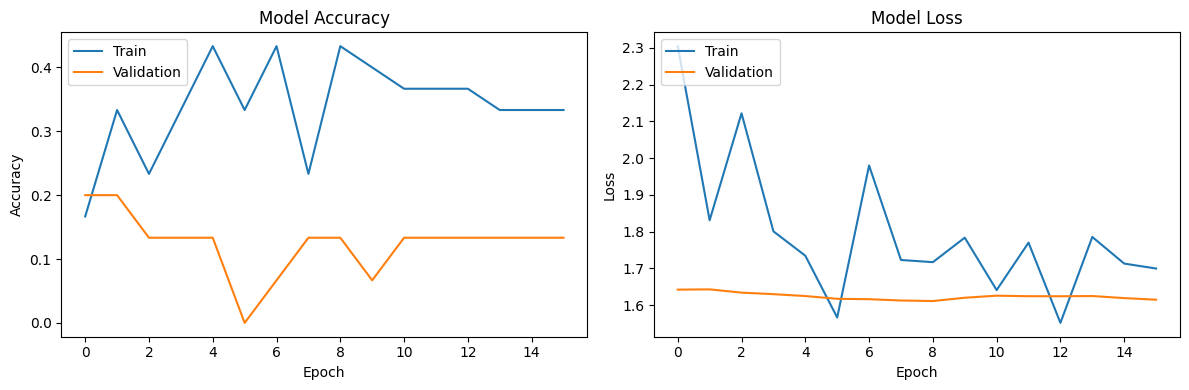

In [9]:
 # evaluate the model
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Prepare to capture the first sign image.
Click the '📸 Capture' button when ready.


<IPython.core.display.Javascript object>


First image captured and saved to: captured_images/sign1_1747003269.jpg


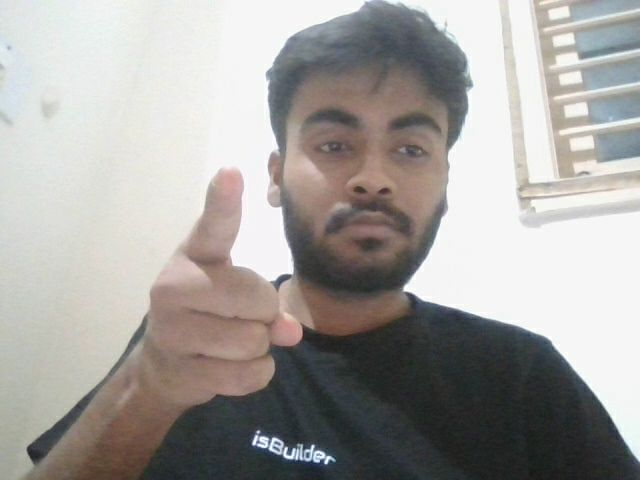


Now prepare to capture the second sign image.
Click the '📸 Capture' button when ready.


<IPython.core.display.Javascript object>


Second image captured and saved to: captured_images/sign2_1747003286.jpg


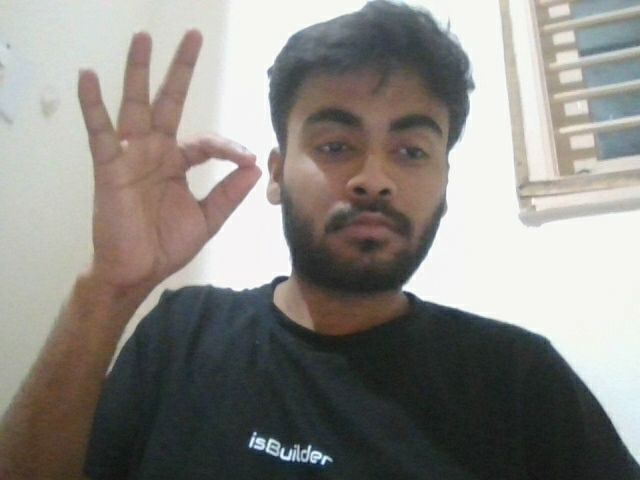


Both images captured successfully!
Ready for prediction with images at:
1: captured_images/sign1_1747003269.jpg
2: captured_images/sign2_1747003286.jpg


In [15]:
# capture two photos sequentially
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import numpy as np
import PIL.Image
import io
import base64
import time
import os

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // resized video feed to square
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      const dataUrl = canvas.toDataURL('image/jpeg', quality);
      return dataUrl;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def take_two_photos(output_dir="captured_images"):
    """
    Captures two photos sequentially using the webcam.

    Args:
        output_dir: Directory to save the captured images

    Returns:
        tuple: (path_to_first_image, path_to_second_image)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1st photo
    print("Prepare to capture the first sign image.")
    print("Click the '📸 Capture' button when ready.")
    timestamp1 = int(time.time())
    photo_path1 = os.path.join(output_dir, f"sign1_{timestamp1}.jpg")
    take_photo(filename=photo_path1)

    # display the captured image
    print(f"\nFirst image captured and saved to: {photo_path1}")
    display(Image(photo_path1))

    # 2nd photo
    print("\nNow prepare to capture the second sign image.")
    print("Click the '📸 Capture' button when ready.")
    timestamp2 = int(time.time())
    photo_path2 = os.path.join(output_dir, f"sign2_{timestamp2}.jpg")
    take_photo(filename=photo_path2)

    # display the captured image
    print(f"\nSecond image captured and saved to: {photo_path2}")
    display(Image(photo_path2))

    print("\nBoth images captured successfully!")
    return photo_path1, photo_path2

# called the function to take 2 photos
photo_path1, photo_path2 = take_two_photos()

print(f"Ready for prediction with images at:\n1: {photo_path1}\n2: {photo_path2}")

Processing first sign image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

Top predictions:
I: 20.94%
tall: 20.70%
you: 20.51%

Final prediction: I (Confidence: 20.94%)

Processing second sign image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

Top predictions:
beautiful: 20.67%
you: 20.60%
I: 20.19%

Final prediction: beautiful (Confidence: 20.67%)


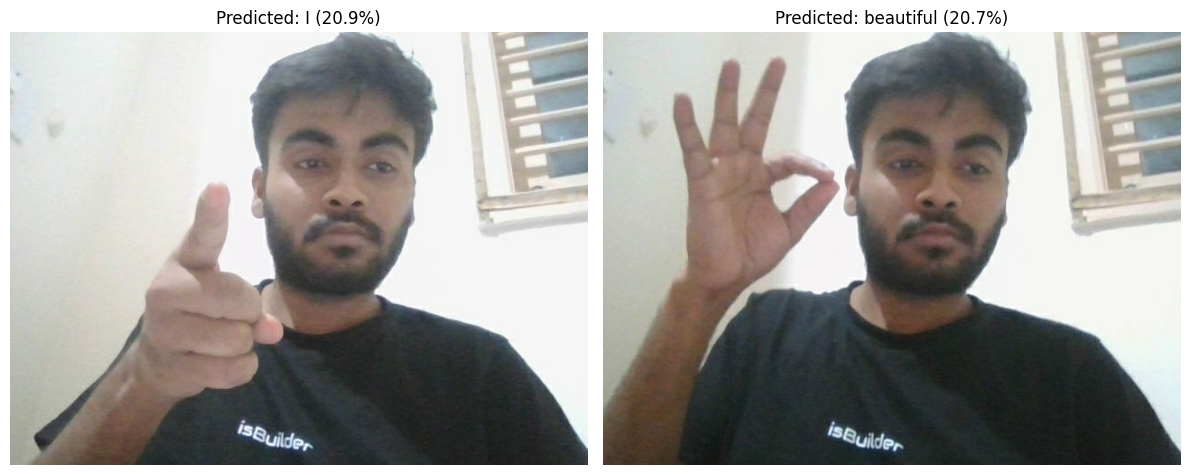


Predicted signs: 'I' and 'beautiful'


In [16]:
# prediction code for multiple images
import matplotlib.pyplot as plt
import numpy as np
import cv2

def preprocess_and_predict(photo_path, model, selected_classes, sequence_length=16, img_size=(112, 112)):
    # load and preprocess the image
    img = cv2.imread(photo_path)
    if img is None:
        print(f"Error: Could not read image at {photo_path}")
        return None

    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0

    # created a sequence by duplicating the image
    sequence = np.array([img for _ in range(sequence_length)])
    sequence = np.expand_dims(sequence, axis=0)

    # make prediction
    prediction = model.predict(sequence)
    predicted_idx = np.argmax(prediction[0])
    predicted_label = selected_classes[predicted_idx]
    confidence = prediction[0][predicted_idx]

    # top 3 predictions with confidence
    top_indices = np.argsort(prediction[0])[-3:][::-1]
    print("\nTop predictions:")
    for idx in top_indices:
        print(f"{selected_classes[idx]}: {prediction[0][idx]*100:.2f}%")

    print(f"\nFinal prediction: {predicted_label} (Confidence: {confidence*100:.2f}%)")

    return predicted_label, confidence

# processed both images and get predictions
print("Processing first sign image...")
predicted_label1, confidence1 = preprocess_and_predict(photo_path1, model, selected_classes)

print("\nProcessing second sign image...")
predicted_label2, confidence2 = preprocess_and_predict(photo_path2, model, selected_classes)

# displayed both images with their predictions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(photo_path1), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_label1} ({confidence1*100:.1f}%)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cv2.imread(photo_path2), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_label2} ({confidence2*100:.1f}%)")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nPredicted signs: '{predicted_label1}' and '{predicted_label2}'")

In [26]:
# import Gemini SDK
!pip install -q -U google-generativeai

import google.generativeai as genai

GEMINI_API_KEY = "enter your api key here"

# configured gemini
genai.configure(api_key=GEMINI_API_KEY)

# use valid gemini model
model_gen = genai.GenerativeModel('models/gemini-2.0-flash')

# sentence generated
def generate_sentence_with_gemini(label1, label2):
    if not label1 or not label2:
        print(" One or both predictions are missing.")
        return

    prompt = (
    f"Create a meaningful 3-word sentence in the format: '{label1} [verb] {label2}', "
    f"where '{label1}' and '{label2}' are traffic or hand sign labels. "
    f"The word in the middle should be a verb that describes a realistic action or interaction where both signs could appear together."
)

    try:
        response = model_gen.generate_content(prompt)
        print("\nGenerated Sentence using Gemini:")
        print(response.text.strip())
    except Exception as e:
        print(f" Error generating sentence: {e}")

# sentence generation using previous inputs
generate_sentence_with_gemini(predicted_label1, predicted_label2)

I am Beautiful
